In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [3]:
%matplotlib notebook

### Datasets

In [10]:
# REad in datasets
# Idealized data
ds_ideal = xr.open_dataset('../../../../out/idealized_1712_1812/FIONA_idealized-3D_DOM01_ML_0001.nc')

# reference data
ds_ref = xr.open_dataset('../../../../out/reference_1712_1812/FIONA-3D_DOM01_ML_0001.nc')

# Only pressure data to find the centerline
pres_ds = xr.open_dataset('../../../Data/pres_data_ideal.nc')


## Find centerline

In [11]:
# Variables for regular lon-lat output
r_deg      = 200*180/(np.pi*6371)    # radius in degrees (200km)
lev        = len(pres_ds.height)
lev_start  = 43                     # Level from where the calculations should begin 
filename   = "../../Data/center_fiona_reference" 
save_center= True                  # Should center array be saved in to "filename"

lonlat_box = {'lon_up':-32.66,'lon_down':-38.96, 'lat_up': 10, 'lat_down': 17.19}   # Direct region of Fiona

center     = np.empty([len(pres_ds.height),2])

lon = pres_ds.lon
lat = pres_ds.lat

In [12]:
# Calculate environment
p_env = [np.mean(pres_ds.pres[0,i].values) for i in range(lev_start-1, lev)]

In [ ]:
# Select region of interest to make calculation faster
#pres_ds = pres_ds.where(pres_ds['lon'] < lonlat_box['lon_up'], drop=True)
#pres_ds = pres_ds.where(pres_ds['lon'] > lonlat_box['lon_down'], drop=True)
#pres_ds = pres_ds.where(pres_ds['lat'] > lonlat_box['lat_up'], drop=True)
#pres_ds = pres_ds.where(pres_ds['lat'] < lonlat_box['lat_down'], drop=True)


<IPython.core.display.Javascript object>


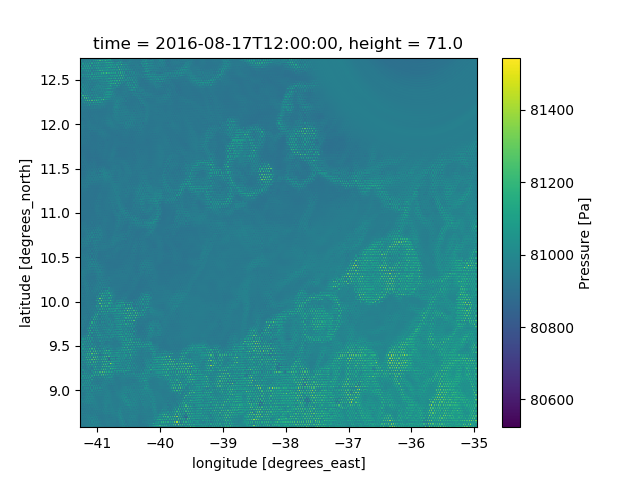

In [14]:
# Plot selected region
pres_ds.pres.isel(time=0, height=-20).plot()

In [ ]:
lev = lev_start

while lev >= lev_start :
    
    # First guess
    single_lev = pres_ds.isel(time = 0, height=lev-1)
    lon_fg = single_lev.where(single_lev == single_lev.min(), \
            drop=True).lon.values[0]
    lat_fg = single_lev.where(single_lev == single_lev.min(), \
            drop=True).lat.values[0]
    
    lon_lim_east = lon_fg + r_deg
    lon_lim_west = lon_fg - r_deg
    lat_lim_north= lat_fg + r_deg
    lat_lim_south= lat_fg - r_deg

    # extract box containing all possible cells in circle
    single_lev = single_lev.where(single_lev['lon'] < lon_lim_east, drop=True)
    single_lev = single_lev.where(single_lev['lon'] > lon_lim_west, drop=True)
    single_lev = single_lev.where(single_lev['lat'] < lat_lim_north, drop=True)
    single_lev = single_lev.where(single_lev['lat'] > lat_lim_south, drop=True)

    lon_array = np.empty([len(single_lev.lon)*len(single_lev.lat)])
    lat_array = np.empty([len(single_lev.lon)*len(single_lev.lat)])
    pres_array = np.empty([len(single_lev.lon)*len(single_lev.lat)])
    dist_array = np.empty([len(single_lev.lon)*len(single_lev.lat)])
    
    # Compute distance of each point to origin (based on fg)
    c = 0
    for lon_i in range(len(single_lev.lon)):
        for lat_i in range(len(single_lev.lat)):
            dist_array[c]= np.sqrt((single_lev.lon.values[lon_i] -lon_fg)**2 \
                  + (single_lev.lat.values[lat_i] - lat_fg)**2)
            lon_array[c] = single_lev.lon.values[lon_i]
            lat_array[c] = single_lev.lat.values[lat_i]
            pres_array[c] = single_lev.pres.values[lat_i, lon_i]
            c += 1
            
    lev -= 1
    
    
lev = len(pres_ds.height)

In [23]:
single_lev = pres_ds.isel(time = 0, height=60)
lon_fg = single_lev.where(single_lev == single_lev.pres.min(), \
            drop=True).lon.values[0]
lat_fg = single_lev.where(single_lev == single_lev.pres.min(), \
            drop=True).lat.values[0]
    
print(lat_fg, lon_fg)
single_lev.pres.min()

13.616 -35.758


<xarray.DataArray 'pres' ()>
array(64606.94140625)
Coordinates:
    time     datetime64[ns] 2016-08-17T12:00:00
    height   float64 61.0

## Evolution of the centerline

In [17]:
center_ref = np.load('../Data/center_fiona_reference.npy')
#center_ideal = np.load('../Data/center_fiona_idealized.npy')


In [18]:
z_ifc = ds_ref.z_ifc.isel(lat=1, lon=1)
center_ideal[1,0:48,0]


NameError: name 'ds_ref' is not defined

In [41]:
lev_start = 1
ncenter = len(center_ref[0,:,0])
lev_center_end = 48

center_ref_lon = center_ref[0,lev_start:lev_center_end,0]
center_ref_lat = center_ref[0,lev_start:lev_center_end,1]

center_ideal_lon = center_tmp[0,:,0]
center_ideal_lat = center_tmp[0,:,1]

levels = ds_ref.z_ifc.values[91-lev_center_end+1:91,0,0]

Text(0.5, 0, 'Height at half level [m]')

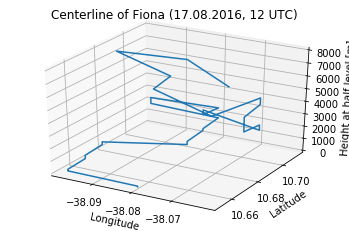

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(np.flipud(center_ref_lon), np.flipud(center_ref_lat), 
        np.flipud(levels))
# Set number of ticks for lon/lat axes
plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.title('Centerline of Fiona (17.08.2016, 12 UTC)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Height at half level [m]')


In [42]:
# Polynomial fit

y_ref = center_ref_lat
x_ref = center_ref_lon

y_ideal = center_ideal_lat
x_ideal = center_ideal_lon

z = levels

#y = y.astype(int)

degree = 3

poly_fit_y_ref = np.poly1d( np.polyfit(z,y_ref, degree) )
poly_fit_x_ref = np.poly1d( np.polyfit(z,x_ref, degree) )

poly_fit_y_ideal = np.poly1d( np.polyfit(z,y_ideal, degree) )
poly_fit_x_ideal = np.poly1d( np.polyfit(z,x_ideal, degree) )

In [36]:
center_tmp.shape
center_ref.shape

(49, 90, 2)

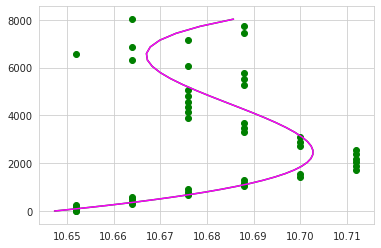

In [46]:
sns.set_style('whitegrid')

plt.figure()
plt.plot(poly_fit_y_ref(z), z, c='green', linestyle='-')
plt.plot(poly_fit_y_ideal(z), z, c='magenta', linestyle='-')

plt.scatter(y_ref,z, c = 'green')
plt.scatter(y_ideal, z, c='magenta')
plt.show()

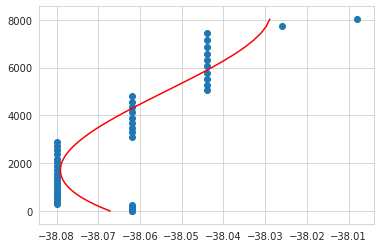

In [40]:
plt.figure()
plt.plot(poly_fit_x_ideal(z), z, c='r', linestyle='-')
plt.scatter(x_ideal,z)
plt.show()

#### Time series

In [45]:
center_tmp= np.load('../Data/tmp_center_1to33.npy')
z = levels

array([[[-3.80620003e+01,  1.06639996e+01],
        [-3.80800018e+01,  1.06879997e+01],
        [-3.80800018e+01,  1.06879997e+01],
        ...,
        [-3.80800018e+01,  1.06520004e+01],
        [-3.80800018e+01,  1.06520004e+01],
        [-3.80800018e+01,  1.06520004e+01]],

       [[-3.80260010e+01,  1.05559998e+01],
        [-3.80439987e+01,  1.05799999e+01],
        [-3.80439987e+01,  1.05920000e+01],
        ...,
        [-3.80620003e+01,  1.05799999e+01],
        [-3.80620003e+01,  1.05799999e+01],
        [-3.80620003e+01,  1.05799999e+01]],

       [[-3.80079994e+01,  1.06040001e+01],
        [-3.80260010e+01,  1.06280003e+01],
        [-3.80439987e+01,  1.06400003e+01],
        ...,
        [-3.80620003e+01,  1.06160002e+01],
        [-3.80620003e+01,  1.06160002e+01],
        [-3.80620003e+01,  1.06160002e+01]],

       ...,

       [[ 4.87830883e+34,  4.88804597e+34],
        [ 4.88451239e+34,  4.87974286e+34],
        [ 4.88399741e+34,  4.88982860e+34],
        ...,
     

In [64]:
ax

<IPython.core.display.Javascript object>


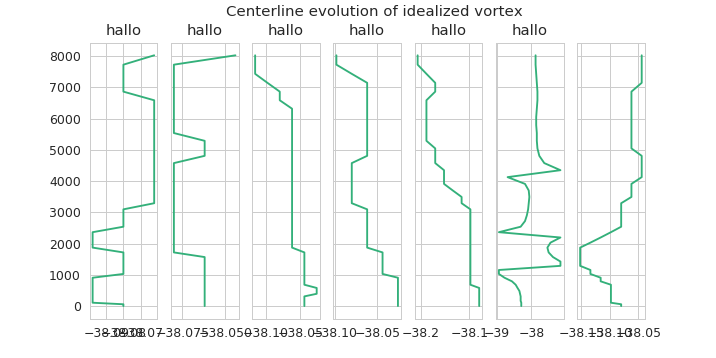

In [108]:
sns.set_style('whitegrid')


timesteps = 33

c_palette = sns.color_palette("husl", 5)
#ncols = timesteps/5
ncols= 7
c= 1

fig = plt.figure(figsize=(8,4))

for t in range(0, timesteps,5):
    ax = fig.add_subplot(1, ncols, c )
    
    # Get rid of labels in middle plots
    if t > 0:
        ax.set_yticklabels([])
        
    plt.plot(center_tmp[t,:,0],z, c = c_palette[2], linestyle='-')
    ax.title.set_text('hallo')
    c += 1

plt.grid=(True)
plt.title('Centerline evolution of idealized vortex', x=-3,y=1.07)
plt.show()